# DL - CNN 

## 1. Imports

In [1]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Rescaling

# model building imports
from keras import Model, Sequential, Input

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

#### Splitting the dataset into Train/ Val/ Test

In [2]:
### Ja feito no outro notebook.

#### Data Loading

In [3]:
train = keras.utils.image_dataset_from_directory(
    directory = r"C:\Users\User\Desktop\deeplearning\dataset_split\train",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    interpolation = "bilinear"
)

validation = keras.utils.image_dataset_from_directory(
    directory = r"C:\Users\User\Desktop\deeplearning\dataset_split\val",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear"
)

test = keras.utils.image_dataset_from_directory(
    directory = r"C:\Users\User\Desktop\deeplearning\dataset_split\test",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear"
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


#### Visualizing the Data

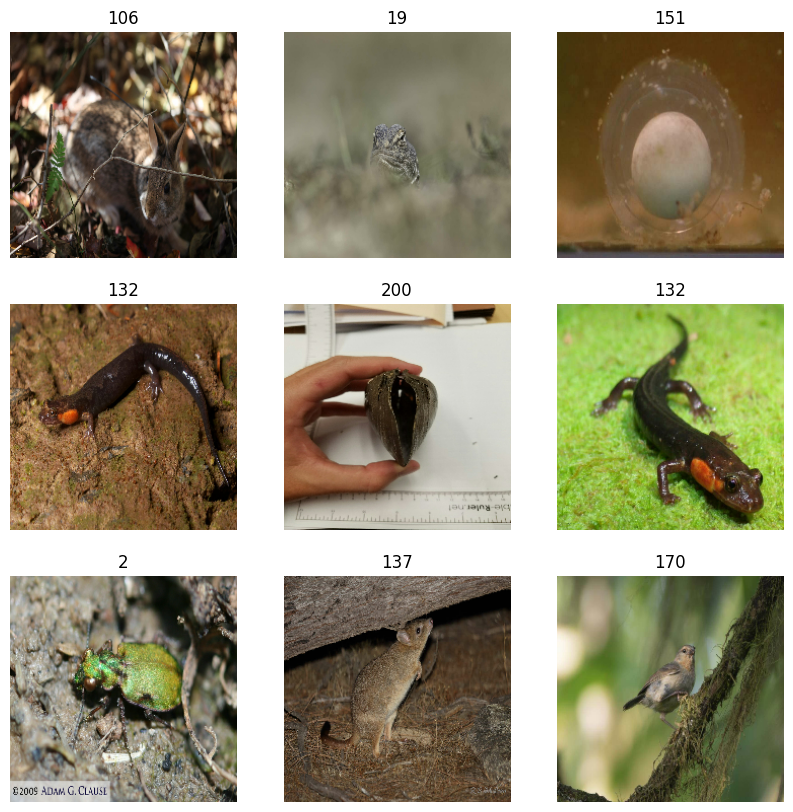

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")

#### Inspecting size to confirmm initial changes:

In [5]:
for images, labels in train.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Min Pixel Value: 255.0


#### Same applies to test and validation sets!

In [6]:
for images, labels in validation.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Min Pixel Value: 255.0


The RGB Channel values are between 0-255 which is not ideal for a CNN, we must resize them between the [0;1] range.

#### Data Augmentation

#### Applying Resizing

In [7]:
normalization = Rescaling(1./255)

train = train.map(lambda x,y: (normalization(x), y))
validation = validation.map(lambda x,y: (normalization(x), y))
test = test.map(lambda x,y: (normalization(x), y))

In [8]:
### Checking RGB Pixel resize:
for images, labels in train.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))


Min Pixel Value: 0.0
Min Pixel Value: 1.0


In [9]:
### Checking RGB Pixel resize:
for images, labels in validation.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))


Min Pixel Value: 0.0
Min Pixel Value: 1.0


In [10]:
### Checking RGB Pixel resize:
for images, labels in test.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))


Min Pixel Value: 0.0
Min Pixel Value: 1.0


<hr>

#### Setting up TensorBoard for Monitorization - Callback

In [11]:
#pip install tensorboard

In [12]:
import datetime
tb_logs = r"C:\Users\User\Desktop\deeplearning"
log_directory = tb_logs + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

### Model Architecture

In [13]:
## Defining the main class which will be called and will contain our model's parameters.
## It inherits from keras.Model class

## Why

class CNN1(Model):

    def __init__(self, activation = "relu"):
        # Calling super().__init__ method refers to the parent class Model.
        # Why is this important? - register the model, it properly initializes the Keras Model class
        # allowing TF to manage layers, forward propagation, and model metadata correctly.

        # Allows Model Methods to Work --> Methods like .fit(), .predict(), and .save(), depend
        # on Model being initialized properly.
        super().__init__()


       #### BLOCK 1
        self.conv1_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_l")
        self.batch1 = BatchNormalization()
        self.conv1_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_r")
        self.batch2 = BatchNormalization()
        self.maxpool1 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool1")

        #### BLOCK 2
        self.conv2_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_l")
        self.batch3 = BatchNormalization()
        self.conv2_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_r")
        self.batch4 = BatchNormalization()
        self.maxpool2 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool2")

        #### FLATTEN AND DENSE
        self.flatten_layer = Flatten()
        self.dropout_layer = Dropout(rate=0.5)
        self.batch5 = BatchNormalization()
        self.dense_layer = Dense(units=202, activation="softmax", name="classification")

    def call(self, inputs):
        x = inputs

        # BLOCK 1
        x_l = self.conv1_l(x)
        x_l = self.batch1(x_l)
        x_r = self.conv1_r(x)
        x_r = self.batch2(x_r)
        x = add(x_l,x_r)  
        x = self.maxpool1(x)

        # BLOCK 2
        x_l2 = self.conv2_l(x)
        x_l2 = self.batch3(x_l2)
        x_r2 = self.conv2_r(x)
        x_r2 = self.batch4(x_r2)
        x = add(x_l2,x_r2)
        x = self.maxpool2(x)

        x = self.flatten_layer(x)
        x = self.dropout_layer(x)
        x = self.batch5(x)
        x = self.dense_layer(x)

        return x

In [14]:
my_callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_directory),
    keras.callbacks.ModelCheckpoint(
        filepath = r"C:\Users\User\Desktop\deeplearning\Projeto.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor = 0.3,
        mode="auto",
        patience=3,
        verbose=1,
        min_lr = 0.0001
    )
]

<hr>

#### Model Summary

In [15]:
model = CNN1()
inputs = Input(shape=(224,224,3))
_ = model.call(inputs)
model.summary()

Model: "cnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_l (Conv2D)                │ (None, 222, 222, 192)  │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_r (Conv2D)                │ (None, 222, 222, 192)  │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 222, 222, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 111, 111, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_l (Conv2D)                │ (None, 109, 109, 192)  │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 109, 109, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_r (Conv2D)                │ (None, 109, 109, 192)  │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 55, 55, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 580800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 580800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 580800)         │     2,323,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 202)            │   117,321,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,322,762 (458.99 MB)

 Trainable params: 119,159,626 (454.56 MB)

 Non-trainable params: 1,163,136 (4.44 MB)

<hr>

#### Training With A subset of the Data

In [16]:
subset_train = train.shuffle(200, seed=10).take(1500)
subset_val = validation.take(300)

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
categorical_accuracy = CategoricalAccuracy(name="accuracy")
metrics = [categorical_accuracy]

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

subset_train = subset_train.cache().prefetch(buffer_size=AUTOTUNE)
subset_val = subset_val.cache().prefetch(buffer_size=AUTOTUNE)


: 

In [ ]:
model.fit(
    subset_train,
    epochs=15,
    validation_data = subset_val,
    callbacks = my_callbacks,
    verbose=2
)

Epoch 1/15


<hr>

#### TensorBoard Monitorization

In [ ]:
%load_ext tensorboard
%tensorboard --logdir= tb_logs